# Hough transform

Using the input step, we repeat the edge detection:

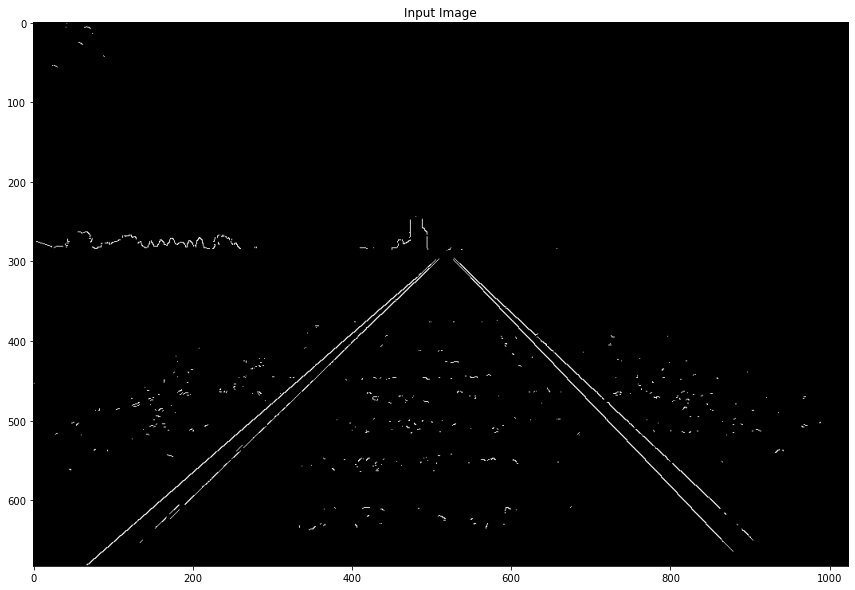

In [1]:
import opencv2 as cv
import math
import matplotlib.pyplot as plt
import numpy as np

input_dir = './input/'
in_img_name = 'Railroad.jpg'
# in_img_name = 'hough_test.png'
in_img = cv.imread(input_dir + in_img_name, cv.IMREAD_GRAYSCALE)

hough_threshold = 300

# Image with 2 white points
# in_img = np.zeros((50,50), np.uint8)
# in_img[10, 25] = 1
# in_img[40, 20] = 1

canny_thresholds = [460, 500]
edges = cv.Canny(in_img, canny_thresholds[0], canny_thresholds[1])
in_img = edges
plt.figure(figsize=(15,10))
plt.imshow(in_img,cmap = 'gray')
plt.title('Input Image')
plt.show()

In [2]:
# Hough transform implementation
img = in_img

rho_step = 1 # 1 pixel rho step
theta_step = np.pi / 180 # 1 degree step in radians
threshold = hough_threshold # acummulator filtering threshold

# theta is calculated from -90 to 90 degrees
min_theta = -np.pi/2
max_theta = np.pi/2

w, h = img.shape

print(w,h)

# maximum and minimum values for rho
# could also calculated as the diagonal of the image
max_rho = w + h
min_rho = -max_rho

# number of values for rho and theta based on input params
num_angle = int(np.floor((max_theta - min_theta) / theta_step) + 1)
num_rho = int(np.round((max_rho - min_rho + 1) / rho_step))

rho_offset = (num_rho - 1) / 2

# accumulator matrix sized larger with 2 to allow calculation of neighbors in the local maximum step
accum = np.zeros((num_rho + 2, num_angle + 2), int)

683 1024


In [3]:
# calculate values for accumulator
for i in range(h):
  for j in range(w):
    # skip black pixels
    if img[j,i] != 0:
      # iterate each angle from -90 to 90
      for n in range(num_angle):
        # theta angle in radians
        angle = min_theta + n * theta_step
        # Rho formula based on theory in hough space
        r = round(j * math.cos(angle) + i * math.sin(angle))
        # Move to center
        r += rho_offset
        # increment accumulator, r+1, n+1 because of the accumulator size + 2
        accum[int(r+1)][n+1] += 1


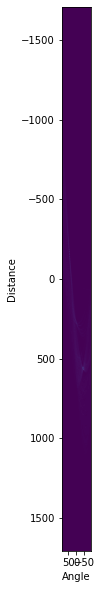

In [4]:
# print accumulator
plt.figure(figsize=(10,10))
plt.imshow(accum,
  extent=[np.rad2deg(max_theta), np.rad2deg(min_theta), max_rho, min_rho])
plt.xlabel('Angle')
plt.ylabel('Distance')
plt.axis('image')
plt.show()

In [5]:
# find local maximums
maximums = []

# compare each value in accumulator with the threshold and the neighbors
# if the value is a maximum, the numeric rho,theta pair is saved
for r in range(1, num_rho):
    for n in range(1, num_angle):
        if accum[r][n] > threshold and \
           accum[r][n] > accum[r][n - 1] and \
           accum[r][n] > accum[r][n + 1] and \
           accum[r][n] > accum[r - 1][n] and \
           accum[r][n] > accum[r + 1][n]:
            maximums.append((r,n))

print(maximums)

[(1566, 48), (2266, 132), (2275, 135)]


In [6]:
# sort maximums by accumulator value
maximums.sort(key=lambda rho_theta: accum[rho_theta[0]][rho_theta[1]])
print(maximums)

[(1566, 48), (2275, 135), (2266, 132)]


In [7]:
# create list of lines
# map the numeric rho,theta pairs back into actual pixels and radians
lines = []
for i in range(len(maximums)):
    r = maximums[i][0]
    n = maximums[i][1]
    rho = (r - rho_offset) * rho_step
    angle = min_theta + n * theta_step
    lines.append((rho, angle))

print(lines)

[(-141.0, -0.7330382858376183), (568.0, 0.7853981633974483), (559.0, 0.7330382858376185)]


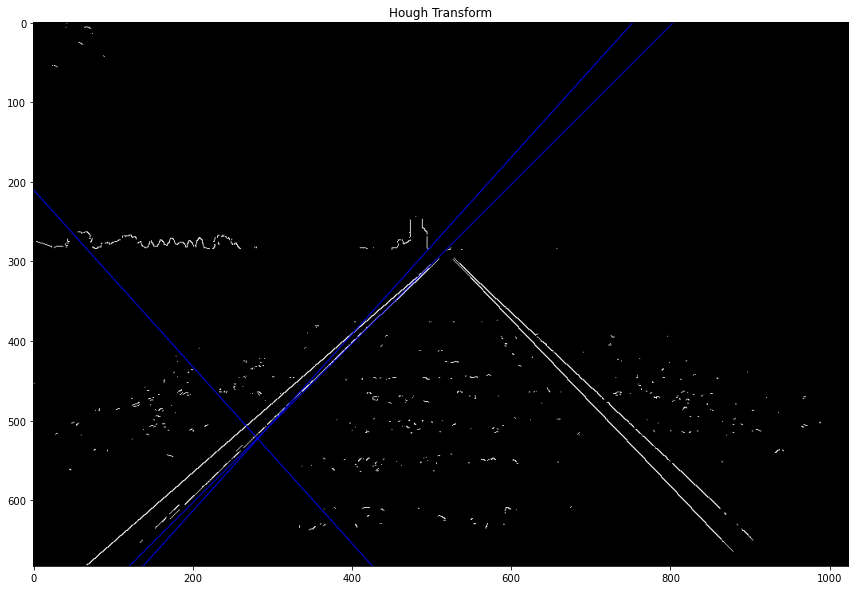

In [8]:
# Draw the lines - same algorithm as OpenCV Hough Transform

# copy the input image, convert to colors so colored lines can be overlaid
output = cv.cvtColor(in_img, cv.COLOR_GRAY2BGR)

# reverse hough transform - from rho and theta, compute x and y 
# scalar is used to properly set the length of the line
scalar = 1e5
for i in range(len(lines)):
    rho = lines[i][0]
    theta = lines[i][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + scalar*(-b)), int(y0 + scalar*(a)))
    pt2 = (int(x0 - scalar*(-b)), int(y0 - scalar*(a)))
    cv.line(output, pt1, pt2, (0,0,255), 1, cv.LINE_AA)

plt.figure(figsize=(15,10))
plt.imshow(output)
plt.title('Hough Transform')
plt.show()